In [1]:
%run notebook_setup.ipynb

In [2]:
import pandas
pandas.set_option('display.max_colwidth', 100)

In [3]:
%vault from pubmed_derived_data import literature

Imported `literature` (E4FB4141) at Sunday, 19. Jul 2020 21:02

In [4]:
has_abstract = ~literature['abstract'].isnull()

**TODO: use title if not abstract, add keywords, use full text if available**

In [5]:
literature['abstract_clean'] = literature['abstract_clean'].fillna('')

In [6]:
domain_features = literature.index.to_frame().copy()

## Domain knowledge / semantic features

Spacy corpus and models are trained on generic web-based texts, not on scientific or biomedical research. In order to make use of named entities it is worth including a minimum of domain-specific terminology:

- chromosomes
  - locus
- mutations
  - in proteins
  - in genes
- gene & protein names
  - entrez identifiers regular expression
  - refseq regular expression
  - MANE
- metabolite names
  - HMDB
- diseases
  - OMIM + ClinVar?
  - an ontology?
- drug names
  - DrugBank
- species
  - NCBI

In [7]:
from pandas import read_table

In [8]:
from helpers.text_processing import (
    check_usage,
    highlight_first,
    matches_n_consecutive_words
)

In [9]:
from functools import partial

check_usage_in_abstracts = partial(check_usage, data=literature, column='abstract_clean')

In [10]:
from tqdm import tqdm
tqdm.pandas()

/home/krassowski/.pyenv/versions/3.8.3/envs/multi-omics/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Diseases

In [11]:
disease_names_df = read_table('data/disease_names')
disease_names_df

,#DiseaseName,SourceName,ConceptID,SourceID,DiseaseMIM,LastModified,Category
0,1-2 finger syndactyly,Human Phenotype Ontology,C4023732,HP:0010704,NaN,16 Feb 2016,Finding
1,1-2 toe complete cutaneous syndactyly,Human Phenotype Ontology,C4025140,HP:0005767,NaN,16 Feb 2016,Finding
2,1-2 toe syndactyly,Human Phenotype Ontology,C4023726,HP:0010711,NaN,16 Feb 2016,Finding
3,1-3 finger syndactyly,Human Phenotype Ontology,C4023730,HP:0010706,NaN,16 Feb 2016,Finding
4,1-3 toe syndactyly,Human Phenotype Ontology,C4025774,HP:0001459,NaN,16 Feb 2016,Finding
...,...,...,...,...,...,...,...
43749,Zygodactyly type 3,MONDO,CN203276,MONDO:0017544,NaN,17 Apr 2020,Disease
43750,Zygodactyly type 4,MONDO,CN203277,MONDO:0017545,NaN,17 Apr 2020,Disease
43751,Zygomycosis,NaN,C0043541,NaN,NaN,16 Feb 2016,Infectious disease
43752,​Keratosis pilaris atrophicans,MONDO,C4310982,MONDO:0018855,NaN,28 Apr 2020,Disease


In [12]:
disease_names_df.Category.value_counts()

Disease                     26046
Finding                     15029
Named protein variant        1117
Infectious disease            951
Pharmacological response      547
Blood group                    63
phenotype instruction           1
Name: Category, dtype: int64

In [13]:
disease_names = disease_names_df[disease_names_df.Category == 'Disease']['#DiseaseName'].str.lower()
len(disease_names.unique())

25922

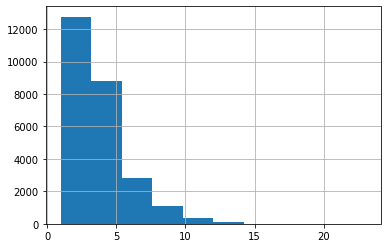

In [14]:
disease_words_count = disease_names.str.split(' ').apply(len)
disease_words_count.hist();

In [15]:
disease_words_count.quantile(0.999)

13.0

In [16]:
ignored_disease_terms = {
    'rare',
    'c',
    'acquired',
    'localized'
}

In [17]:
mentioned_diseases = literature['abstract_clean'].str.lower().progress_apply(
    matches_n_consecutive_words,
    database=set(disease_names) - ignored_disease_terms,
    consecutive_n=int(disease_words_count.quantile(0.999))
)

100%|██████████| 3347/3347 [00:04<00:00, 832.57it/s] 


In [18]:
domain_features['first_mentioned_diseases'] = mentioned_diseases
domain_features['mentions_diseases'] = mentioned_diseases.isnull()

In [19]:
mentioned_diseases.sorted_value_counts().head(50)

index
cancer                         625
disease                        492
carcinoma                       79
cardiovascular                  40
diabetes                        39
inflammation                    39
aging                           29
glioblastoma                    26
adenocarcinoma                  25
obesity                         25
injury                          22
melanoma                        17
pregnancy                       14
fibrosis                        12
schizophrenia                   12
stroke                          12
glioma                          10
transplantation                 10
inherited                        8
osteoarthritis                   8
myeloid leukemia                 6
atrial fibrillation              5
insulin resistance               5
lymphoma                         5
cardiomyopathy                   4
depressive disorder              4
developmental delay              4
glaucoma                         4
influenza     

In [20]:
clinical_findings = disease_names_df[disease_names_df.Category == 'Finding']['#DiseaseName'].str.lower()
len(clinical_findings.unique())

15014

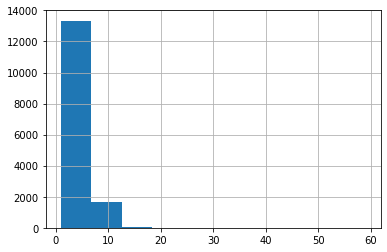

In [21]:
clinical_findings_words_count = clinical_findings.str.split(' ').apply(len)
clinical_findings_words_count.hist();

In [22]:
ignored_findings_terms = {
    'none',
    'add',
    '5)',
    'id',
    'delay',
    'diagnostic',
    'healthy',
    'affected',
    'array',
    'falls',
    'obligate',
    # quantifiers
    'all',
    'mild',
    'frequent',
    'progressive',
    'frequency',
    'mitochondrial',
    'symptomatic'
}

In [23]:
mentioned_findings = literature['abstract_clean'].str.lower().progress_apply(
    matches_n_consecutive_words,
    database=set(clinical_findings) - ignored_findings_terms,
    consecutive_n=int(clinical_findings_words_count.quantile(0.999))
)

100%|██████████| 3347/3347 [00:11<00:00, 290.23it/s]


In [24]:
domain_features['first_mentioned_clinical_finding'] = mentioned_findings
domain_features['mentions_clinical_findings'] = mentioned_findings.isnull()

In [25]:
mentioned_findings.sorted_value_counts().head(50)

index
breast cancer                 111
asthma                         27
leukemia                       27
infections                     26
prostate cancer                25
plethora                       18
psychiatric                    18
colitis                        16
arthritis                      15
colon cancer                   14
atherosclerosis                13
dissection                     12
hypoxia                        12
autism                         11
bladder cancer                 11
shock                          11
asymptomatic                   10
heart failure                  10
poor prognosis                 10
hepatitis                       9
streptococcus                   9
cholangiocarcinoma              8
dementia                        7
osteoporosis                    7
pain                            7
sepsis                          7
allergy                         6
bipolar                         6
anxiety                         5
chronic 

## Species

In [26]:
species = read_table('data/taxdump/names.dmp', usecols=[2, 4, 6])
species.columns = ['name', 'unique_name', 'type']
species

,name,unique_name,type
0,root,NaN,scientific name
1,Bacteria,Bacteria <bacteria>,scientific name
2,bacteria,NaN,blast name
3,eubacteria,NaN,genbank common name
4,Monera,Monera <bacteria>,in-part
...,...,...,...
3234121,Lebrunia neglecta,NaN,synonym
3234122,"Lilyopsis medusa (Metschnikoff & Metschnikoff, 1871)",NaN,authority
3234123,Lilyopsis medusa,NaN,scientific name
3234124,Lilyopsis rosea,NaN,synonym


In [27]:
species.type.sorted_value_counts()

index
scientific name        2260403
authority               503986
synonym                 169589
type material           149465
includes                 53463
equivalent name          49097
genbank common name      29623
common name              14493
acronym                   1197
genbank synonym           1110
in-part                    535
genbank acronym            483
anamorph                   284
blast name                 229
teleomorph                 169
Name: type, dtype: int64

In [28]:
head = species.head(100)
head.query('type == "type material"').tail(5)

,name,unique_name,type
89,ATCC 39565,ATCC 39565 <type strain>,type material
90,ATCC BAA-642 [[Shewanella affinis Ivanova et al. 2004]],ATCC BAA-642 [[Shewanella affinis Ivanova et al. 2004]] <type strain>,type material
91,CIP 107703 [[Shewanella affinis Ivanova et al. 2004]],CIP 107703 [[Shewanella affinis Ivanova et al. 2004]] <type strain>,type material
92,KMM 3587 [[Shewanella affinis Ivanova et al. 2004]],KMM 3587 [[Shewanella affinis Ivanova et al. 2004]] <type strain>,type material
97,strain LST-W,strain LST-W <type strain>,type material


In [29]:
species_names = set(
    species[(species.name != 'root') & ~species.type.isin({'authority', 'type material'})]
    .name
    .str.lower()
)
len(species_names)

2572241

In [30]:
species_type_materials = set(
    species[species.type.isin({'type material'})]
    .name
    # remove the citation from type material, take the name only
    .str.split(r' \[\[').str[0]
)
len(species_type_materials)

148755

In [31]:
assert 'human' in species_names
assert 'homo sapiens' in species_names

### Manual species curation

Note: type materials have to be case-sensitive:

In [32]:
species[species.name.str.lower() == 'and']

,name,unique_name,type
1871628,AND,AND <type material>,type material


Cancer is a proper genus, but we do not want to match it as it would match cancer as a disease:

In [33]:
species[species.name.str.lower() == 'cancer']

,name,unique_name,type
31637,Cancer,NaN,scientific name


None of the articles appears to refer to a fish when they use "spot" either:

In [34]:
species[species.name.str.lower() == 'spot']

,name,unique_name,type
123457,spot,NaN,common name


In [35]:
check_usage_in_abstracts('spot')

uid
21831800    genomics level, exome sequencing has been the hot spot of the recent research. However, the pred...
25345010    riptomics and proteomics, is becoming the new hot spot of life science. Although the fast output...
31162831                                              Target spot is a newly emerging citrus disease caused by 
31616468    ean or median of the pixel intensities within the spot and then subjected to a within-slide norm...
Name: abstract_clean, dtype: object

Python is used as a programming language:

In [36]:
check_usage_in_abstracts('Python')

uid
23927696    available software.\n\n\nHere, we describe COBRA for Python (COBRApy), a Python package that pro...
25637560    _pipe). Omics Pipe is distributed as a standalone Python package for installation (https://pypi....
26072472    D IMPLEMENTATION\nMSProGene is written in Java and Python. It is open source and available at ht...
27986083    lated within a user-friendly implementation using Python and Docker. IMP is available at http://...
28640810    nted as a general-purpose toolbox using the PyGMO Python package to make the most of multicore c...
29746212    umber of examined species were identified using a Python script. Multiple genomic alignments of ...
30221093    lack of adequate data analysis training (e.g., R, Python) as a main challenge, in addition to no...
30596886    http://b2slab.upc.edu/software-and-tutorials/ and Python package: https://pypi.python.org/pypi/m...
30668675    //rgv.genouest.org. The website is implemented in Python, JavaScript and MongoDB, and is

California is used as place:

In [37]:
check_usage_in_abstracts('California')

uid
21194970    troprusside (SNP). QuantiGene (Panomics, Fremont, California) branched DNA (bDNA) assay was used...
28443069    . At "Long-term Soil Productivity Study" sites in California dominated by Ponderosa pine, we tes...
29339647    NN) held its 11th annual Congress in Los Angeles, California, between September 16 and 19, 2017....
29688803    dosis related omics evidence in the University of California Santa Cruz (UCSC) Genome Browser. F...
31299210    nd PCBs, in a women cohort with sera collected in California in the 1960s. Strikingly, this anal...
31825540    n," was held 20 to 23 June, 2019, in Los Angeles, California.\n\n\nThe CHPCA Meeting is an annua...
Name: abstract_clean, dtype: object

In [38]:
check_usage_in_abstracts('codon')

uid
26482106    ion to a changing environment: pathway structure, codon usage, metabolism. To measure adaptabili...
26850284    s data and subsets thereof to establish reference codon usage biases for codon optimization in s...
27633273    gnments, conservation and variation, CpG islands, codon context, usage bias and phylogenetic inf...
29222764    mplemented in MATLAB. METRADE uses microarray and codon usage data to model bacterial metabolic ...
30066640     collection of gene expression and sequence data, codon usage and protein abundances) to analyse...
31046701    p.Arg5688*), predicted to create a premature stop codon near the N-terminus of ADGRV1. Ophthalmo...
31071195    t Saccharomycopsis yeasts have reassigned the CTG codon and translate CTG into serine instead of...
32041497    417C→A variant introduces a premature termination codon (Y139X). We found reduced CHK2 protein e...
Name: abstract_clean, dtype: object

In [39]:
check_usage_in_abstracts('glycine')

uid
23883549    y butanol treatment. Notably, 3-phosphoglycerate, glycine, serine and urea related to general st...
27228119    esults suggested reprogrammed pathways related to glycine metabolism, fatty acids metabolism and...
27589727    in "phosphoglycerate mutase 2" and the metabolite glycine. We hypothesize that association studi...
27879288    RJ, CD44, and C4A, as well as increased levels of glycine and asparagine, and decreased levels o...
29325019    G sites, i.e. of glycerophospholipid PC(O-36: 5), glycine and a very low-density lipoprotein (VL...
29859941    fermentation pathways of the amino acids proline, glycine and leucine. But also a far-reaching r...
29930756    gnificantly altered glutamine, glucose and serine/glycine metabolism. The predominant upregulate...
30086113    tes (uridine, C-glycosyl tryptophan, and N-acetyl glycine) were statistically independent and th...
31029960    red metabolites, the metabolic pathway containing glycine, serine and threonine was the 

In [40]:
check_usage_in_abstracts('anemia')

uid
22960126    ta thalassemia (Het-βThal). Het-βThal causes mild anemia and is known to determine a pro-oxidant...
26948278    oorly understood. Moreover, current management of anemia in ESRD is controversial due to the "an...
27136057    at risk for a drug side effect (ribavirin-induced anemia) and how genetic variation (inosine tri...
29590102    cal phenotypes such as red blood cell parameters, anemia, and chronic kidney disease (CKD). In a...
Name: abstract_clean, dtype: object

In [41]:
check_usage_in_abstracts('hippocampus')

uid
27731396    files of PLF and PSF groups were acquired for the hippocampus and plasma to identify molecular p...
28300637    tabolite assignments from three ROIs (cerebellum, hippocampus and midbrain/hypothalamus) in posi...
30291623    filed the transcriptome and proteome of the mouse hippocampus during early stages of disease dev...
31942070                                                 The hippocampus is an important part of the limbic sys
32170004    essed in liver, brain cerebellum, frontal cortex, hippocampus and pituitary. Our studies provide...
32234596    significantly increased the levels of BDNF in the hippocampus. Cecum contents metabolomics revea...
Name: abstract_clean, dtype: object

Mixed usage: as referring to species or in another meaning:

In [42]:
check_usage_in_abstracts('indicator')

uid
26421150    with asthma. The outcome of interest was a binary indicator of asthma control defined by the use...
26444894     occurring within the warfighter as a preclinical indicator. Current methods for determining tox...
26870025    rRNA gene amplicon sequencing and methods such as indicator species analysis, the Kolmogorov-Smi...
28335448    . The multi-omics data, in combination with fecal indicator bacteria (FIB) counts, trace metal c...
29222764    sion, metabolism is increasingly being used as an indicator of the phenotypic outcome for drugs ...
29844878    non-coding RNA, which is known to be a prognostic indicator for breast cancer and stimulated by ...
30189879    e the ability to passively monitor behavior as an indicator of socialization and mood; accumulat...
31054440                  Ambient fine particle is a crucial indicator of air pollution brought into the air by
31258819    sing its human development index (HDI): a summary indicator of health, education, and in

But majority indicators would be false-positives, excluding; "fecal indicator bacteria" will match anyways on "bacteria".

Numeric only records are to vague and will be excluded to avoid false positives:

In [43]:
species[species.name == '382']

,name,unique_name,type
905354,382,382 <type material>,type material


In [44]:
numeric_species_terms = {name for name in species.name if name.isnumeric()}
len(numeric_species_terms)

146

Some other species names excluded:

In [45]:
species[species.name.str.lower() == 'collection']

,name,unique_name,type
2217657,collection,NaN,scientific name


In [46]:
ignored_species_terms = {
    'cancer',
    'other',
    'collection',
    'synthetic',
    'artificial',
    'unknown',
    'none',
    'unidentified',
    'hybrid',
    'clinical samples',
    'vectors',
    'spot',
    'this',
    'data',
    'major',
    'colon',
    'cnv',  # copy number variation
    'goes',
    'automate',
    'axis',
    'idea',
    'laser',
    'beta',
    'areas',
    'electron',
    'bias',
    'python',
    'cis',  # chemistry prefix
    'insertion',
    'aa',   # amino acid
    'california',
    'codon',    # in sequence
    'glycine',  # amino acid
    'anemia',   # disease
    'hippocampus',
    'meta',
    'indicator'
}

Some names are just long:

In [47]:
x = Series(list(species_names))
x[x.str.len() > 100].head()

95140     (megalobrama amblycephala x megalobrama terminalis) x (megalobrama amblycephala x megalobrama te...
111532    cloning vector pb-5-xor-degron-tvmvs-mcp-cnot7-tevs-degron-e2a-mcp-tevs-tvmvs-cnot7-f2a-ntevp-fr...
208823    cloning vector pb-4-nor-degron-tvmvs-mcp-cnot7-e2a-mcp-cnot7-tevs-degron-f2a-ntevp-frb-t2a-fkbp-...
255626    influenza a virus (a/reassortant/idcdc-rg18(texas/05/2009 x new york/18/2009 x puerto rico/8/193...
378050    influenza a virus (a/reassortant/ai05ga(a/chicken/korea/ms96/1996 x a/wild bird/cheongju/vi0408/...
dtype: object

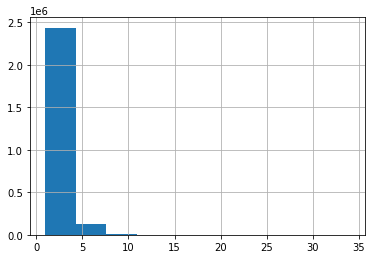

In [48]:
species_words_count_distribution = x.str.split(' ').apply(len)
species_words_count_distribution.hist();

For sanity, will only check for species names up to 8 words long (which captures 99.9% of the terms):

In [49]:
species_words_count_distribution.quantile(0.999)

8.0

In [50]:
mentioned_species_type_material = literature['abstract_clean'].str.lower().progress_apply(
    matches_n_consecutive_words,
    database=species_type_materials - numeric_species_terms,
    consecutive_n=int(species_words_count_distribution.quantile(0.999))
)

100%|██████████| 3347/3347 [00:05<00:00, 622.82it/s]


In [51]:
mentioned_species_type_material.value_counts()

Series([], Name: abstract_clean, dtype: int64)

In [52]:
assert mentioned_species_type_material.isnull().all()

In [53]:
mentioned_species = literature['abstract_clean'].str.lower().progress_apply(
    matches_n_consecutive_words,
    database=species_names - ignored_species_terms - numeric_species_terms,
    consecutive_n=int(species_words_count_distribution.quantile(0.999))
)

100%|██████████| 3347/3347 [00:02<00:00, 1218.05it/s]


In [54]:
domain_features['first_mentioned_species'] = mentioned_species
domain_features['mentions_species'] = mentioned_species.isnull()

In [55]:
len(mentioned_species.value_counts())

323

In [56]:
mentioned_species.sorted_value_counts().head(50)

index
human              518
mouse               84
microbiota          79
mice                61
plants              37
bacteria            33
humans              28
escherichia         27
rat                 24
rice                17
saccharomyces       17
rats                15
maize               12
arabidopsis         11
bacterium           11
gut microbiome      11
animals             10
fungi                9
soybean              9
eukaryotes           8
fish                 8
mycobacterium        8
sepsis               8
chinese hamster      7
aspergillus          6
cyanobacteria        6
plasmodium           6
rodent               6
viruses              6
zebrafish            6
algae                5
bovine               5
cotton               5
drosophila           5
nematode             5
pseudomonas          5
streptococcus        5
tobacco              5
bacillus             4
clostridium          4
coronavirus          4
glaucoma             4
mammals              4
metag

In [57]:
microbiota_terms = [
    'microbiota', 'gut microbiome',
    # maybe - needs context
    'metagenome'
]

In [58]:
mentioned_species.sorted_value_counts().head(100).tail(50)

index
bacteroidetes        3
bear                 3
cattle               3
chlamydomonas        3
dogs                 3
phyla                3
potato               3
rhodococcus          3
rhodosporidium       3
sclerotinia          3
soil microbiome      3
streptomyces         3
acinetobacter        2
apple                2
archaea              2
athletes             2
b virus              2
borrelia             2
caenorhabditis       2
chicken              2
chickens             2
clostridioides       2
corn                 2
cyanobacterium       2
e. coli              2
fev                  2
folsomia             2
fusarium             2
hbv                  2
ignicoccus           2
ipa                  2
leishmania           2
mammoth              2
mayo                 2
metagenomes          2
mota                 2
pea                  2
pig                  2
populus              2
radix                2
rhodotorula          2
saccharopolyspora    2
sheep                2
steno

In [59]:
domain_features['mentions_species'].mean(), domain_features['mentions_species'].sum() / has_abstract.sum()

(0.5482521661189125, 0.5642681426814268)